In [1]:
import itertools as iter
from itertools import product

import time

import pandas as pd
import numpy as np
import triangle as tri 

from scipy.stats import norm
from scipy.optimize import linprog

from matplotlib import pyplot as plt


from mpl_toolkits.mplot3d import Axes3D

import pypoman

import cdd as pcdd

import fractions as frac

In [2]:
def f(p): #funcion a evaluar
    x = p[0]
    y = p[1]
    if y <= 1.0e-6:
        y = 1.0e-6
    f = (1/y)*((0.5*((x*x+1)*(1-norm.cdf(x))-(x*norm.pdf(x))))-(0.5*(((x+y)*(x+y)+1)*(1-norm.cdf(x+y))-((x+y)*norm.pdf(x+y)))))
    
    if f <= 1.0e-7:
        f = 1.1e-7
    return f

#gsl_cdf_ugaussian_P == norm.cdf
#These functions compute the cumulative distribution functions P(x), Q(x) and their inverses for the unit Gaussian distribution.


#gsl_ran_ugaussian_pdf == norm.pdf
#These functions compute results for the unit Gaussian distribution. They are equivalent to the functions above with a standard deviation of one, sigma = 1.

def df1dx (x,y): #funcion a evaluar
    if y <= 1.0e-6:
        y = 1.0e-6
    f = (1/y)*((norm.pdf(x+y)-(x+y)*(1-norm.cdf(x+y)))-(norm.pdf(x)-x*(1-norm.cdf(x))))
    return f  

def df1dy (x,y): #funcion a evaluar
    if y <= 1.0e-6:
        y = 1.0e-6
    f = -(1/(y*y))*((0.5*((x*x+1)*(1-norm.cdf(x))-(x*norm.pdf(x))))-(0.5*(((x+y)*(x+y)+1)*(1-norm.cdf(x+y))-((x+y)*norm.pdf(x+y)))))+(1/y)*(norm.pdf(x+y)-(x+y)*(1-norm.cdf(x+y)))
    return f

def gradf(p):
    x = p[0]
    y = p[1]
    return np.array([df1dx(x,y),df1dy(x,y)])
def gradf2(p):
    x = p[0]
    y = p[1]
    return np.array([df1dx(x,y),df1dy(x,y),-1.0])

def fSH(a,x):
    return f(a) + np.dot(gradf(a),(x-a))

def e_i(n,i):
    vector = np.zeros(n)
    vector[i-1] = np.ones(1)[0]

    return vector

def pad(matriz, dimensiones):
    return np.pad(matriz,dimensiones, mode = 'constant', constant_values=(0, 0))

def linap (p,cuts, c,m):
    return max(c[str(cut)]+np.dot(m[str(cut)],p) for cut in cuts)

In [3]:
def to_points(triangulo):
    puntos = triangulo["vertices"]
    simplices = triangulo["triangles"]

    lista = []

    for pp in simplices:
        a = puntos[pp[0]]
        b = puntos[pp[1]]
        c = puntos[pp[2]]

        lista.append([a,b,c])

    return lista

def array_index(T, a):
    for i, arr in enumerate(T):
        if np.array_equal(arr, a):
            return i
    raise ValueError(f'{a} is not in list')

def triag_listo(T,v):
    a = v[0]
    b = v[1]
    c = v[2]
    
    aa = array_index(T,a)
    bb = array_index(T,b)
    cc = array_index(T,c)
    seg = [[aa,bb],[bb,cc],[cc,aa]]

    x = (a+b+c)/3
    return seg, x   

In [4]:
#Primera pasada
lb = float(1.0e-6)
ub = float(5.0)
a = np.array([0.0,lb])
b = np.array([ub,ub])
og = False

k=0

X = dict()
Y = dict()
D = dict()

data = dict()

deltaabs = np.infty
deltarel = np.infty
epsabs = float(1.0e-4) #No cambiar de 1.0e-5
epsrel = float(1.0e-4)

if not og:
    bordes = np.array([a,[0.0,ub],[ub,lb],b])
    dominio_temp = dict()

    dominio_temp["vertices"] = bordes

    triangulo_temp = tri.triangulate(dominio_temp, opts="qca0.5") #area!

    for p in triangulo_temp["vertices"]:
        k+=1
        deltaabs = max(f(p),0.0)
        deltarel = deltaabs/f(p)


        X[k] = p
        Y[k] = np.nan

        if deltaabs <= epsabs or deltarel <= epsrel:
            D[k] = 0
            Terminar = True

        data[k] = {"GEN": 0, "X": X[k],"X1" :  X[k][0], "X2" :  X[k][1], "Y": Y[k],"f(x)": f(p),"difabs": deltaabs, "difrel":deltarel}
else:
    X[k] = e_i(2,2)*lb #R^2
    Y[k] = np.zeros(1) #R

    D[k] = 1

    data[k] = {"GEN": 0, "X": X[k], "X1" :  X[k][0], "X2" :  X[k][1], "Y": Y[k], "f(x)": f(X[k]), "difabs": f(a)-0.0, "difrel": 1}


    while k < 1e6:
        Terminar = False

        soluciones = dict()

        p = X[k]

        for i in [1,2]:
            for c in [lb,ub]:

                lhsA = np.array([gradf(p),
                                e_i(2,i-1)])
                rhsb = np.array([np.dot(gradf(p),p)-f(p), c])

                ecs = np.linalg.solve(lhsA,rhsb)
                way = max(fSH(p,ecs),0.0)

                if np.less_equal(a/2.0,ecs).all() and np.less_equal(ecs,b+a/2.0).all():
                    soluciones[str(ecs)] = (ecs,way)

        if len(soluciones) < 1.0:
            ecs_s = b
            way_s = max(fSH(p,b),0)
            Terminar = True

        else:
            maximo = -1*np.infty
            for key in soluciones.keys():
                val = soluciones[key]
                if val[1] > maximo:
                    maximo = val[1]
                    ecs_s = val[0]
                    way_s = maximo

        deltaabs = f(ecs_s)-way_s
        deltarel = deltaabs/f(ecs_s)

        k+=1

        X[k] = ecs_s
        Y[k] = way_s

        if deltaabs <= epsabs or deltarel <= epsrel:
            D[k] = 0
            Terminar = True

        data[k] = {"GEN": 0, "X": X[k],"X1" :  X[k][0], "X2" :  X[k][1], "Y": Y[k],"f(x)": f(p),"difabs": deltaabs, "difrel":deltarel}

        if Terminar:
            break

    df = pd.DataFrame(data).transpose()
    #Añade los vértices del cuadrado del dominio
    extremos = np.array([[0.0,ub],[ub,lb],b])
    for p in extremos:
        if p not in df["X"].values:
            k+=1
            X[k] = p
            Y[k] = 0.0
            data[k] = {"GEN": 0,"X": X[k], "X1" :  X[k][0], "X2" :  X[k][1], "Y": Y[k],"f(x)": f(p),"difabs": deltaabs, "difrel":deltarel}
df = pd.DataFrame(data).transpose()

In [5]:
df

,GEN,X,X1,X2,Y,f(x),difabs,difrel
1,0,"[0.0, 1e-06]",0.0,0.000001,NaN,0.398942,0.398942,1.0
2,0,"[0.0, 5.0]",0.0,5.0,NaN,0.05,0.05,1.0
3,0,"[5.0, 1e-06]",5.0,0.000001,NaN,0.0,0.0,1.0
4,0,"[5.0, 5.0]",5.0,5.0,NaN,0.0,0.0,1.0
5,0,"[2.5, 1e-06]",2.5,0.000001,NaN,0.002004,0.002004,1.0
6,0,"[0.0, 2.5000005]",0.0,2.500001,NaN,0.09976,0.09976,1.0
7,0,"[0.6250001250000123, 1.8750006249999998]",0.625,1.875001,NaN,0.043623,0.043623,1.0
8,0,"[1.25, 2.5000007500000248]",1.25,2.500001,NaN,0.008481,0.008481,1.0
9,0,"[0.0, 1.2500007499999999]",0.0,1.250001,NaN,0.183033,0.183033,1.0
10,0,"[0.0, 3.7500002500000003]",0.0,3.75,NaN,0.066665,0.066665,1.0


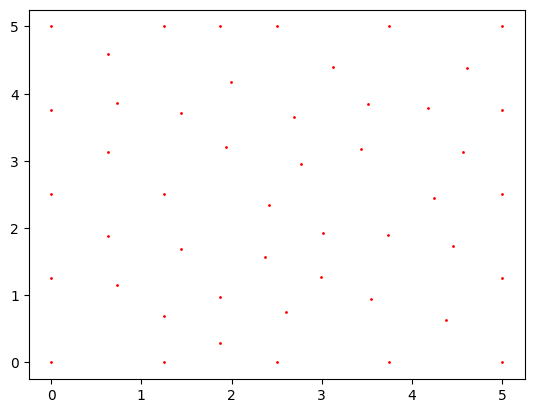

In [6]:
ex = df["X"].values.tolist()

px = []
py = []

for x in ex:
    px.append((x[0]))
    py.append((x[1]))


plt.scatter(px, py, s=1, c = "red")
plt.show()

In [7]:
dominio = dict()

vertices = df["X"].values.tolist()
holes = []
segments = [[0,1],[1,3],[3,2],[2,0]]

dominio["vertices"] = vertices
dominio["segments"] = segments
#dominio["vertices"] = []

triangulo = tri.triangulate(dominio, opts="p")

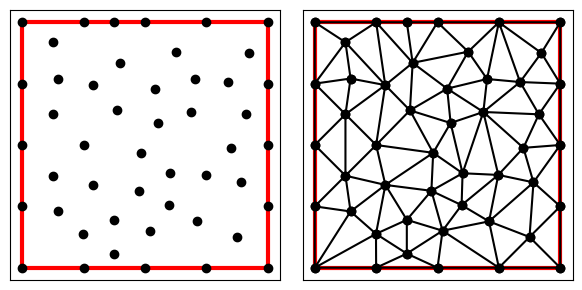

In [8]:
tri.compare(plt, dominio, triangulo)
plt.show()

Error numerico en la creacion del politopo
Número de Tanda: 1, delta = 3.1, k = 84


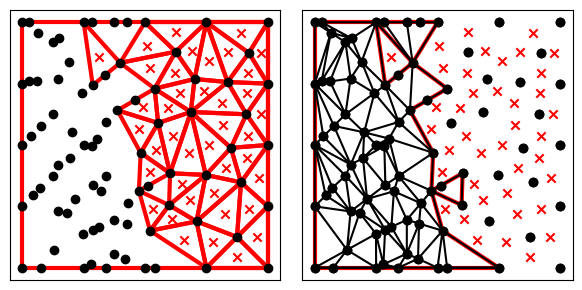

Angulo extremadamente pequeño
Angulo extremadamente pequeño
Número de Tanda: 2, delta = 6.6, k = 166


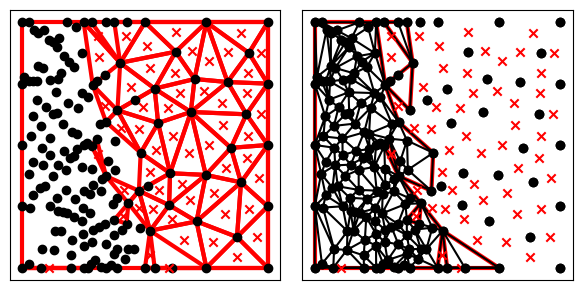

Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Número de Tanda: 3, delta = 16.7, k = 316


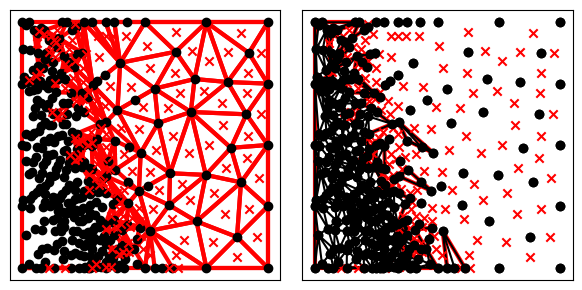

Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Número de Tanda: 4, delta = 31.9, k = 518


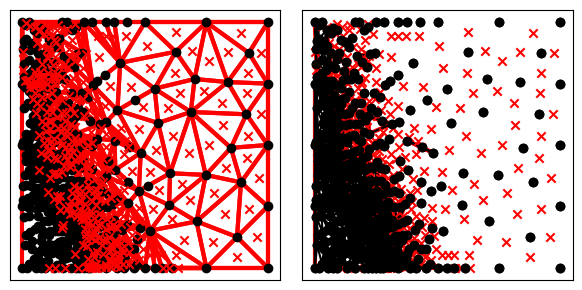

Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño


C:\Users\nico_\AppData\Local\Temp\ipykernel_10472\1113099216.py:43: RuntimeWarning: invalid value encountered in arccos
  a_c = np.arccos(np.dot(l_a,l_b))
C:\Users\nico_\AppData\Local\Temp\ipykernel_10472\1113099216.py:41: RuntimeWarning: invalid value encountered in arccos
  a_a = np.arccos(np.dot(l_b,l_c))


Angulo extremadamente pequeño
Angulo extremadamente pequeño


C:\Users\nico_\AppData\Local\Temp\ipykernel_10472\1113099216.py:42: RuntimeWarning: invalid value encountered in arccos
  a_b = np.arccos(np.dot(l_a,l_c))


Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Número de Tanda: 5, delta = 44.8, k = 707


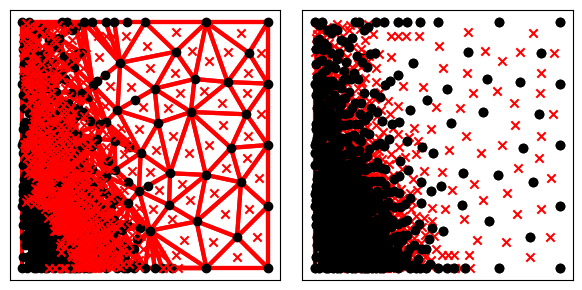

Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Número de Tanda: 6, delta = 53.1, k = 853


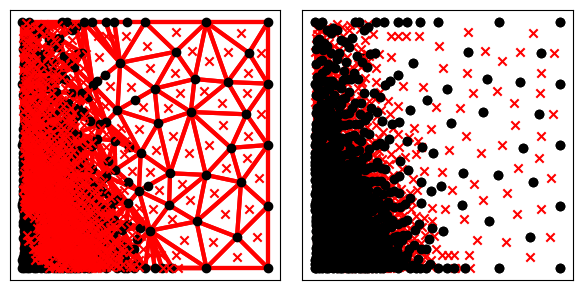

Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Número de Tanda: 7, delta = 52.1, k = 89

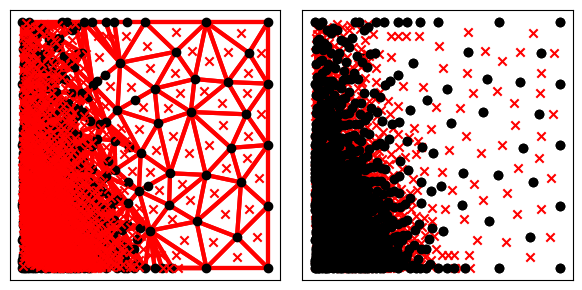

Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Número de Tanda: 8, delta = 23.0, k = 901


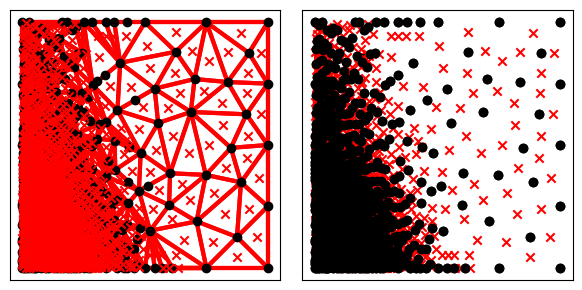

Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Número de Tanda: 9, delta = 15.1, k = 903


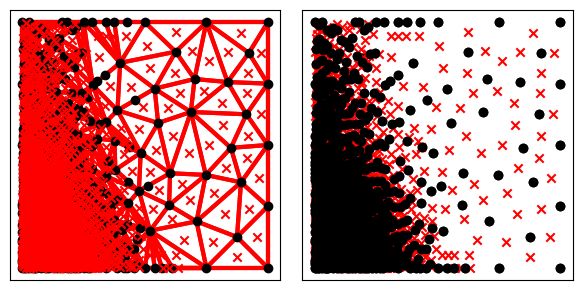

Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Número de Tanda: 10, delta = 10.9, k = 904


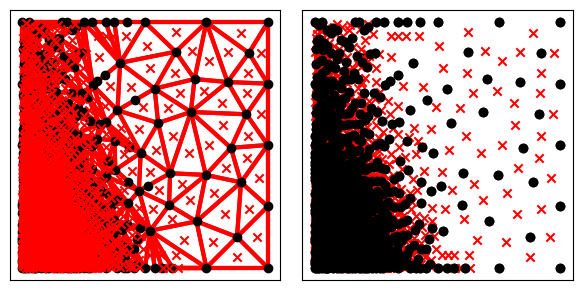

Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Angulo extremadamente pequeño
Número de Tanda: 11, delta = 9.1, k = 904


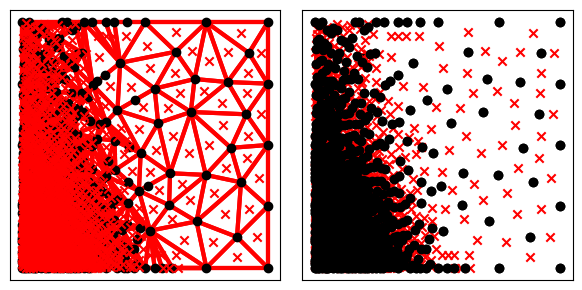

In [9]:
#Segunda pasada
tandas = [to_points(triangulo)]
lim = 2000

A_cuts = np.zeros([3])
b_cuts = np.zeros(1)

for cut in dominio["vertices"]:
    A_cuts = np.vstack([A_cuts, gradf2(cut)])
    b_cuts = np.append(b_cuts, np.dot(gradf(cut),cut)-f(cut))

A_cuts = np.delete(A_cuts, 0,0)
b_cuts = np.delete(b_cuts, 0,0)

for simplices in tandas:
    nuevos_k = 0
    start = time.time()
    if k+1 >= lim:
        break
    
    for simplex in simplices:
        v = dict()
        v[1] = simplex[0]
        v[2] = simplex[1]
        v[3] = simplex[2]

        max_f = max(f(v[i]) for i in [1,2,3])
        max_radii = 0
        min_angle = np.infty

        l_a = v[1]-v[2]
        l_b = v[2]-v[3]
        l_c = v[3]-v[1]
        
        max_radii = max(np.linalg.norm(l_a),np.linalg.norm(l_b),np.linalg.norm(l_c))
        
        l_a = l_a/np.linalg.norm(l_a)
        l_b = l_b/np.linalg.norm(l_b)
        l_c = l_c/np.linalg.norm(l_c)
        
        a_a = np.arccos(np.dot(l_b,l_c))
        a_b = np.arccos(np.dot(l_a,l_c))
        a_c = np.arccos(np.dot(l_a,l_b))
        
        angulo_a = min(a_a,a_b,a_c)

        if angulo_a*360 <= np.pi:
            print("Angulo extremadamente pequeño")
            seg, x = triag_listo(vertices, simplex)
            for s in seg:
                segments.append(s)
            holes.append(x)
            continue
            
        bari = (sum (v[i] for i in [1,2,3]))/3
        A_cuts2 = np.zeros([3])
        b_cuts2 = np.zeros([1])

        se_añadio = False
        for cut in vertices:
            if np.linalg.norm(bari-cut) <= max_radii*1.01:   #############
                A_cuts2 = np.vstack([A_cuts2, gradf2(cut)])
                b_cuts2 = np.vstack([b_cuts2, np.dot(gradf(cut),cut)-f(cut)])
                se_añadio = True

        
        A_cuts2 = np.delete(A_cuts2, 0, 0)
        b_cuts2 = np.delete(b_cuts2, 0, 0)

        A_dom, b_dom_temp = pypoman.duality.compute_polytope_halfspaces([
            np.append(v[1],0.0),
            np.append(v[1],f(v[1])),
            np.append(v[2],0.0),
            np.append(v[2],f(v[2])),
            np.append(v[3],0.0),
            np.append(v[3],f(v[3])),
            ])
        
        #A_dom = np.vstack([A_dom, e_i(3,3)])#Las ultimas 2 son degeneradas!
        b_dom = np.zeros([1])                    #same here
        for bb in b_dom_temp:
            b_dom = np.vstack([b_dom, np.array([bb])])
        #b_dom = np.vstack([b_dom, max_f*1.1])
        b_dom = np.delete(b_dom, 0, 0)
        
        if se_añadio:
            A = np.vstack([A_dom,A_cuts2])
            b = np.vstack([b_dom,b_cuts2])
        else:
            A = A_dom
            b = b_dom

        M = np.hstack((b,-A))
        #Ext = pypoman.duality.compute_polytope_vertices(A,b)
        mat = pcdd.Matrix(M,linear=False, number_type='fraction')
        mat.rep_type = pcdd.RepType.INEQUALITY

        poly = pcdd.Polyhedron(mat)
        Ext = poly.get_generators()

        maximo = -np.inf
        solucion_final = []
        for ecs in Ext:
            #ecs = np.array(ecs)

            x = np.vectorize(float)(ecs[1:3])
            #x = ecs[1:3]
            z = np.vectorize(float)(ecs[3])
            #z = ecs[3]
            
            if f(x) >= maximo+z:               #QUIZAS... AGREGARLE EL CORTE Z=0? (CON UN MAX{...,0}) !!!!!!!!!!!!!!!!!!!!!!!!!!!!
                solucion_final = np.vectorize(float)(ecs[-3:])
                #solucion_final = ecs[-3:]
                maximo = f(x) - z             #x2 ^

        if len(solucion_final) == 0:
            print("Error numerico en la creacion del politopo")
            seg, x = triag_listo(vertices, simplex)
            for s in seg:
                segments.append(s)
            holes.append(x)
            continue
        ecs_s = solucion_final[0:2]
        way_s = solucion_final[2]

        if ecs_s[1] <= 1.0e-6:
           ecs_s[1] =  1.0e-6

        deltaabs = f(ecs_s) - way_s
        #deltarel = deltaabs/f(ecs_s)
        
        if f(ecs_s) <= epsabs+way_s:# or deltarel <= epsrel:
            seg, x = triag_listo(vertices, simplex)
            for s in seg:
                segments.append(s)
            holes.append(x)
            continue

        if ecs_s[0] <= 1.0e-6:
            continue

        k+=1
        nuevos_k+=1

        X[k] = ecs_s
        Y[k] = way_s



        data[k] = {"GEN": len(tandas), "X" :  X[k],"X1" :  X[k][0], "X2" :  X[k][1], "Y": Y[k],"f(x)": f(ecs_s),"difabs": deltaabs, "difrel":deltarel}

        vertices.append(ecs_s)

        A_cuts = np.vstack([A_cuts, gradf2(ecs_s)])
        b_cuts = np.append(b_cuts, np.dot(gradf(ecs_s),ecs_s)-f(ecs_s))

        if k+1 >= lim:
            break
    
    dominio["vertices"] = vertices
    dominio["segments"] = segments
    dominio["holes"] = holes

    triangulo = tri.triangulate(dominio, "p")
    print("Número de Tanda: "+str(len(tandas))+", delta = "+str(round(time.time()-start,1))+", k = "+str(k))
    tri.compare(plt, dominio, triangulo)
    plt.show()
    if nuevos_k > 0:
        tandas.append(to_points(triangulo))

In [10]:
for vertice in vertices:
    print(vertice[1])

1e-06
5.0
1e-06
5.0
1e-06
2.5000005
1.8750006249999998
2.5000007500000248
1.2500007499999999
3.7500002500000003
1e-06
1.1458341458333439
3.125000375
5.0
4.1734375713797345
3.8541668958333273
0.9753799891528945
1.6867542281682106
3.6480795261833894
2.340569017046501
0.6898963176733506
0.2874478174508853
1.8904313335890146
2.5000005
3.1726973499364437
1.5666548786579364
0.7541801780218715
1.9246371498009363
3.2057398033065505
5.0
5.0
3.7197462682060505
1e-06
2.94798206414511
4.400618906685785
5.0
4.375000125000001
3.7500002500000003
3.7828229456017137
3.125000375
2.4420600818054705
4.592803191287876
0.9440471182826817
1.25000075
1.739119188172514
1.275405306110368
0.6257948239253258
3.8444189523465484
1.0000000000288848e-06
0.06830005101029281
0.36312126461469674
1.4726087628353595
1.4021943662605414
1.6307655728575199
1.12008639581006
0.8997070625600863
1e-06
1.313315454121471
0.7743592067605644
1.8666674006936368
1.5567802921403537
2.2323979956175752
0.18275293383641852
0.8325397910452

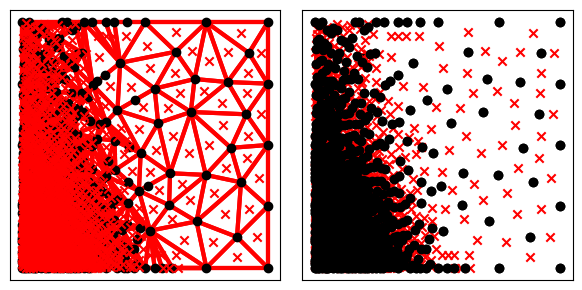

In [11]:
df2 = pd.DataFrame(data).transpose()
tri.compare(plt, dominio, triangulo)
plt.show()

In [12]:
print(k)
print(len(df2))
print(len(simplices))

904
904
41


In [13]:
#print(df2.to_markdown())

### POR QUE HAY VALORES NEGATIVOS?

Por mientras, los parchearé a la mala...

C:\Users\nico_\AppData\Local\Temp\ipykernel_10472\4216198164.py:7: RuntimeWarning: divide by zero encountered in log10
  px.append(np.log10(x[0]))


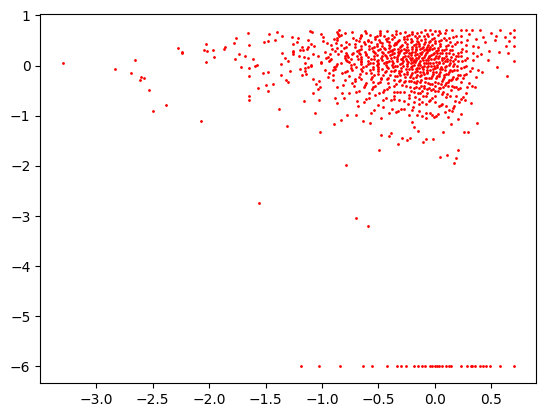

In [14]:
ex = df2["X"].values.tolist()

px = []
py = []

for x in ex:
    px.append(np.log10(x[0]))
    py.append(np.log10(x[1]))


plt.scatter(px, py, s=1, c = "red")
plt.show()

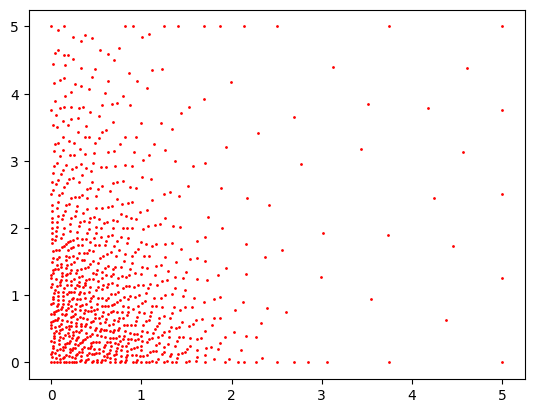

In [15]:
ex = df2["X"].values.tolist()

px = []
py = []

for x in ex:
    px.append(x[0])
    py.append(x[1])


plt.scatter(px, py, s=1, c = "red")
plt.show()

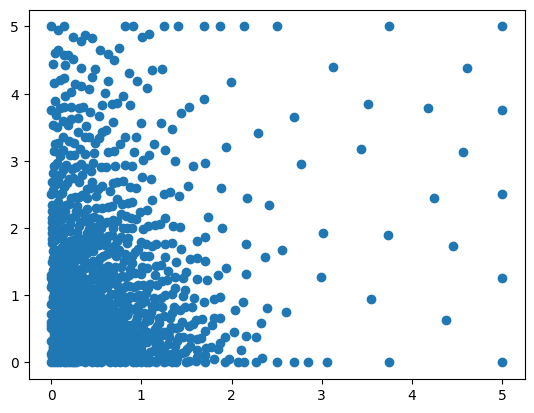

In [16]:
pepes = df2["X"].values.tolist()

pepes = np.array(pepes)

tri2 = tri.triangulate({"vertices": pepes}, "c")
plt.plot(pepes[:,0], pepes[:,1], 'o')
plt.show()

In [17]:
print(len(df2)-len(df), len(df))

856 48


In [18]:
puntox1  = np.random.rand(1000,2)*(ub-lb)+lb
puntox2  = []

for n in puntox1:
    puntox2.append(np.array([n[0], n[1], f(n)]))
puntox2 = np.array(puntox2)


In [19]:
def f(p): #funcion a evaluar
    x = p[0]
    y = p[1]
    
    f = (1/y)*((0.5*((x*x+1)*(1-norm.cdf(x))-(x*norm.pdf(x))))-(0.5*(((x+y)*(x+y)+1)*(1-norm.cdf(x+y))-((x+y)*norm.pdf(x+y)))))
    
    return f

#gsl_cdf_ugaussian_P == norm.cdf
#These functions compute the cumulative distribution functions P(x), Q(x) and their inverses for the unit Gaussian distribution.


#gsl_ran_ugaussian_pdf == norm.pdf
#These functions compute results for the unit Gaussian distribution. They are equivalent to the functions above with a standard deviation of one, sigma = 1.

def df1dx (x,y): #funcion a evaluar
    f = (1/y)*((norm.pdf(x+y)-(x+y)*(1-norm.cdf(x+y)))-(norm.pdf(x)-x*(1-norm.cdf(x))))
    return f  

def df1dy (x,y): #funcion a evaluar
    f = -(1/(y*y))*((0.5*((x*x+1)*(1-norm.cdf(x))-(x*norm.pdf(x))))-(0.5*(((x+y)*(x+y)+1)*(1-norm.cdf(x+y))-((x+y)*norm.pdf(x+y)))))+(1/y)*(norm.pdf(x+y)-(x+y)*(1-norm.cdf(x+y)))
    return f

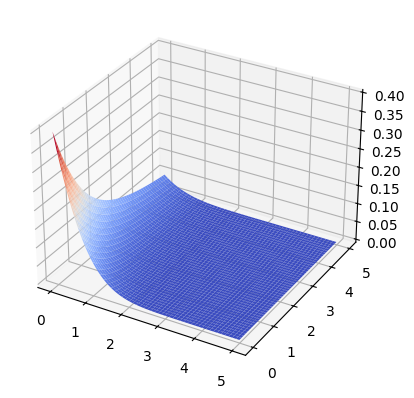

In [20]:
from matplotlib import cm

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

#X = puntox2[:,0]
X = np.arange(lb, ub, 0.01)
Y = np.arange(lb, ub, 0.01)
#Y = puntox2[:,1]

X,Y = np.meshgrid(X,Y)

Z = f((X,Y))

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=True)

plt.show()


In [21]:
Teacher_cuts = pd.read_excel(r'C:\Users\nico_\Desktop\mem\Codigos\profe\Code_C_shortage_barrido\cortes.xlsx', header = 0).iloc[:,1:3]

In [22]:
Teacher_cuts

,param x1:=,param y1:=
0,x,y
1,0,0.000001
2,0,1.596001
3,0,3.486001
4,1.12,0.000001
...,...,...
1997,1.158,0.951001
1998,0.326,1.490001
1999,2.046,1.885001
2000,0.027,1.219001


C:\Users\nico_\AppData\Local\Temp\ipykernel_10472\3059026019.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  px.append(x[0])
C:\Users\nico_\AppData\Local\Temp\ipykernel_10472\3059026019.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  py.append(x[1])


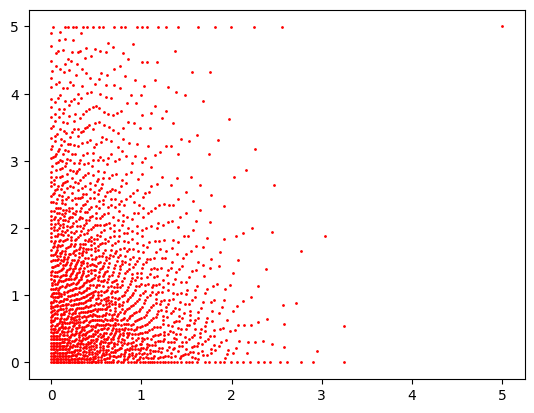

C:\Users\nico_\AppData\Local\Temp\ipykernel_10472\3059026019.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if x[0] == 0:
C:\Users\nico_\AppData\Local\Temp\ipykernel_10472\3059026019.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  px2.append(np.log10(x[0]))
C:\Users\nico_\AppData\Local\Temp\ipykernel_10472\3059026019.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  py2.append(np.log10(x[1]))


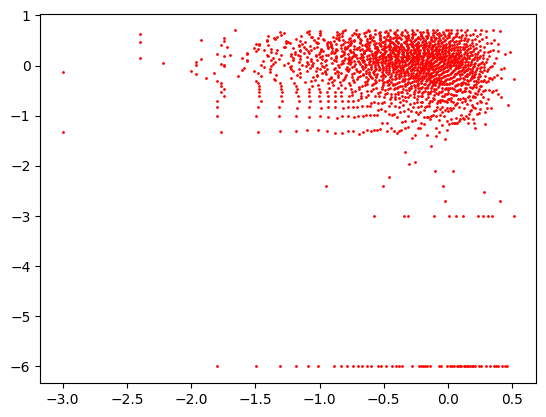

In [23]:
px = []
px2 = []
py = []
py2 = []

for n in Teacher_cuts.index:
    if n > 0:
        x = Teacher_cuts.iloc[n]
        px.append(x[0])
        py.append(x[1])

px.append(ub)
py.append(ub)
plt.scatter(px, py, s=1, c = "red")
plt.show()

for n in Teacher_cuts.index:
    if n > 0:
        x = Teacher_cuts.iloc[n]
        if x[0] == 0:
            continue
        px2.append(np.log10(x[0]))
        py2.append(np.log10(x[1]))


plt.scatter(px2, py2, s=1, c = "red")
plt.show()

In [24]:
print()

## Comprobación ##


In [34]:
my_cuts = df2.iloc[:,1:4]

In [35]:
cuts = my_cuts.iloc[:,0].values

c = dict()
m = dict()

for cut in cuts:
    c[str(cut)] = f(cut) - np.dot(gradf(cut),(cut))
    m[str(cut)] = gradf(cut)

In [27]:
for n in range(0,100,1):
    linap(np.array([2,2]),cuts,c,m)

In [36]:
n=45

contador = 0
h = (ub-lb)/n
doomx = []
doomy = []

x = 0.0
while x < ub:
    y = lb
    while y < ub:
        z = linap(np.array([x,y]),cuts,c,m)
        if f((x,y)) >= epsabs + z:
            doomx.append(x)
            doomy.append(y)
            contador+=1
        y+= h
    x+= h

In [37]:
contador/n**2

0.0004938271604938272

# $Old$

2k cortes: 3.84%

1k cortes: 7.52%

500 cortes: 12.48%

250 cortes: 19.68%


# $New$

2k cortes: 0.00%

1k cortes: 2.47%

500 cortes: 9.36%

250 cortes: 17.91%

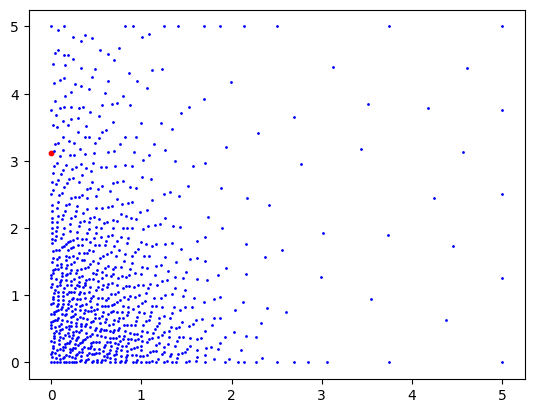

In [38]:
px = []
py = []

for n in range(len(doomx)):
    x = doomx[n]
    y = doomy[n]
    px.append(x)
    py.append(y)

plt.scatter(px, py, s=10, c = "red")


plt.scatter(df2["X1"], df2["X2"], s=1, c = "blue")
plt.show()